In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split,cross_validate
from sklearn import metrics
from sklearn.decomposition import PCA

# Cam added
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE

In [2]:
#import all 3 routes
route1 = pd.read_csv('data_route1/route1processeddata.csv')
route1['route'] = 1
route2 = pd.read_csv('data_route2/route2processeddata.csv')
route2['route'] = 2
route3 = pd.read_csv('data_route3/route3processeddata.csv')
route3['route'] = 3

In [3]:
#combine all 3 routes
df = pd.concat([route1,route2,route3],axis = 0)

In [4]:
#filter for Dockability & Rideability
df = df[df['Dockability']*df['Releasability'] == 1]
#df.describe()

In [5]:
#functions for creating categories
def utcicat(row):
    if row['utcivar1'] < -40:
        val = -5
    elif (-40 <= row['utcivar1'] and row['utcivar1'] <-27):
        val = -4
    elif (-27 <= row['utcivar1'] and row['utcivar1'] <-13):
        val = -3 
    elif (-13 <= row['utcivar1'] and row['utcivar1'] <0):
        val = -2 
    elif (0<= row['utcivar1'] and row['utcivar1'] <9):
        val = -1
    elif (9 <= row['utcivar1'] and row['utcivar1'] <26):
        val = 0
    elif (26 <= row['utcivar1'] and row['utcivar1'] <28):
        val = 1 
    elif (28 <= row['utcivar1'] and row['utcivar1'] <32):
        val = 2
    elif (32 <= row['utcivar1'] and row['utcivar1'] <38):
        val = 3
    elif (38 <= row['utcivar1'] and row['utcivar1'] <46):
        val = 4
    elif (row['utcivar1'] >= 46):
        val = 5
    return val

def precipitationcat(row):
    if row['Precipitation'] == 0:
        val = 0
    else:
        val = 1
    return val

def hourcat(row):
    if row['Hour'] <= 6: 
        val = 'midnight'
    elif row['Hour'] <= 10: 
        val = 'morning'
    elif row['Hour'] <= 13:
        val = 'early_afternoon'
    elif row['Hour'] <= 17:
        val = 'late_afternoon'
    elif row['Hour'] <= 23:
        val = 'evening'
    return val

def countcat(row): 
    if row['count'] == 0: 
        val = 0 
    elif row['count'] <= 2:
        val = 1
    elif row['count'] >= 3: 
        val = 2
    return val

def weekendcat(row):
    year = str(int(row['Year']))
    
    month = int(row['Month'])
    month = str(("0" if month < 10 else "")) + str(month)
    
    day = int(row['Day'])
    day = str(("0" if day < 10 else "")) + str(day)
    
    hour = int(row['Hour'])
    hour = str(("0" if hour < 10 else "")) + str(hour)
    
    inputstring = year + month + day + hour
    datetime = pd.to_datetime(inputstring,format='%Y%m%d%H')
    day = datetime.dayofweek
    isWeekend = 1 if day > 4 else 0
    return isWeekend
    

In [6]:
#set up categorical predictors
df['utcivar1_cat'] = df.apply(utcicat, axis=1)
df['precipitation_cat'] = df.apply(precipitationcat, axis=1)
df['hour_cat'] = df.apply(hourcat, axis=1)
df['count_cat'] = df.apply(countcat, axis=1)
df['weekend'] = df.apply(weekendcat, axis=1)

In [7]:
#drop unecessary columns
df = df.drop(['DateTime','Dockability','Releasability'],axis =1)
df.head()

,Year,Month,Day,Hour,DBT,RelHum,WSp,Precipitation,Elev,utcivar1,utcivar2,utcivar3,count,specialdate,route,utcivar1_cat,precipitation_cat,hour_cat,count_cat,weekend
2649,2017.0,4.0,21.0,9.0,6.7,100.0,7.7,0.0,52.392654,-5.488704,-9.169357,-9.233817,0.0,0,1,-2,0,morning,0,0
2650,2017.0,4.0,21.0,10.0,6.7,96.0,8.2,0.0,58.334083,-6.296706,-9.999895,-10.068702,1.0,0,1,-2,0,morning,1,0
2651,2017.0,4.0,21.0,11.0,7.2,97.0,7.2,0.0,59.503749,-3.105039,-6.808441,-6.900785,0.0,0,1,-2,0,early_afternoon,0,0
2652,2017.0,4.0,21.0,12.0,6.7,100.0,8.2,0.0,55.398772,-5.578307,-9.260705,-9.355655,0.0,0,1,-2,0,early_afternoon,0,0
2653,2017.0,4.0,21.0,13.0,6.7,100.0,7.2,0.0,47.574727,-3.979534,-7.688882,-7.775989,0.0,0,1,-2,0,early_afternoon,0,0


# setting constraints on time interval for Set C (weekday afternoon + non-specialdate + weekday)

In [8]:
#create separate dataframe for set D 
df2 = df.copy()[(df['specialdate'] == 0) & (df['Hour'] >= 13) & (df['Hour'] <= 17) & (df['weekend'] == 0 )]
#non-special dates, from 1pm to 6pm, weekdays

# data prep for set A1,A2,B (incl. train_test_split)

In [9]:
#set A,B,C's data prep
df = df.drop(['Day','Elev','utcivar2','utcivar3'],axis=1)
X = df.drop(['count','count_cat'],axis = 1)
y_cts = df['count']
y_cat = df['count_cat']

In [10]:
catcols = ['utcivar1_cat','Hour','Month']
X = pd.get_dummies(X,columns = catcols, drop_first = False)

In [11]:
X_train, X_test, y_cts_train, y_cts_test, y_cat_train,y_cat_test = train_test_split(X,y_cts,y_cat, train_size = 0.8)

# data prep for set C (incl. train_test_split)

In [12]:
#set C data prep
df2 = df2.drop(['Day','Elev','utcivar2','utcivar3'],axis=1)
X2 = df2.drop(['count','count_cat'],axis = 1)
y2_cts = df2['count']
y2_cat = df2['count_cat']

In [13]:
catcols2 = ['utcivar1_cat','Hour','Month']
X2 = pd.get_dummies(X2,columns = catcols2, drop_first = False)

In [14]:
#train,test,split for set C
X2_train, X2_test, y2_cts_train, y2_cts_test, y2_cat_train,y2_cat_test = train_test_split(X2,y2_cts,y2_cat, train_size = 0.8)

# Preparing columns required for each set

In [15]:
#if you need this: (Example use at bottom)

#for set A1,A2,B
precipitationCols = ['precipitation_cat']

specialDateCols = ['specialdate']

weekendCols = ['weekend']
        
hourCols = [X_train.columns[i] for i in range(len(X_train.columns)) if ("Hour" in X_train.columns[i])]

monthCols = [X_train.columns[i] for i in range(len(X_train.columns)) if ("Month" in X_train.columns[i])]

utciCols = [X_train.columns[i] for i in range(len(X_train.columns)) if ("utcivar1_cat" in X_train.columns[i])]

weatherCols = ['DBT', 'RelHum', 'WSp']

#for set C 
hour2Cols = [X2_train.columns[i] for i in range(len(X2_train.columns)) if ("Hour" in X2_train.columns[i])]

month2Cols = [X2_train.columns[i] for i in range(len(X2_train.columns)) if ("Month" in X2_train.columns[i])]

##combining cols for each set
a1cols = utciCols + precipitationCols + specialDateCols + weekendCols + hourCols + monthCols

a2cols = ['utcivar1'] + precipitationCols + specialDateCols + weekendCols + hourCols + monthCols #main distinction: utcivar1

bcols = weatherCols + precipitationCols + specialDateCols + weekendCols + hourCols + monthCols #main distinction: weatherCols 

ccols = ['utcivar1'] + precipitationCols + hour2Cols + month2Cols #main distinction: no special date or weekend

#example use:

#for 'a1' model,
#notice the use of 'acols' in the fitting and scoring stage@

#model = RandomForestClassifier(max_depth = max_depth, n_estimators = n_estimators,random_state = rs,class_weight = "balanced_subsample", oob_score = True))
#model.fit(X_train[a1cols],y_train,sample_weight = True)
#trainscore = model.score(X_train[a1cols],y_train)
#testscore = model.score(X_test[a1cols],y_train)

#do the same for set a2,b,c

# KKN

In [16]:
def scale(X,features):
    scaler = MinMaxScaler()
    return scaler.fit_transform(X[features])

def scale_split(X,y,features):
    n = X.shape[0]
    frac = n // 5
    idx = np.random.choice(n, replace = True, size = frac)
    X = X.iloc[idx]
    y = y.iloc[idx]
    X = scale(X,features)
    # Uses SMOTE for unbalanced classes
    X,y = SMOTE().fit_resample(X,y)
    return (X,y)

def get_acc(true,pred):
    return round(accuracy_score(true,pred),4)

def progress():
    print('-')

In [17]:
# Set A
X, y = scale_split(X_train,y_cat_train,a1cols)
test = scale(X_test,a1cols)
leaf_size = list(range(20,40))
n_neighbors = list(range(1,11))

n_train_acc = []
n_val_acc = []

l_train_acc = []
l_val_acc = []

print('N Neighbors')
for n in n_neighbors:
    knn = KNeighborsClassifier(n_neighbors=n)
    scores = cross_validate(knn, X, y, cv=3,return_train_score=True)
    n_train_acc.append(np.mean(scores['train_score']))
    n_val_acc.append(np.mean(scores['test_score']))
    progress()
print('Leaf')
for l in leaf_size:
    knn = KNeighborsClassifier(leaf_size = l)
    scores = cross_validate(knn, X, y, cv=3,return_train_score=True)
    l_train_acc.append(np.mean(scores['train_score']))
    l_val_acc.append(np.mean(scores['test_score']))
    progress()    

N Neighbors
-
-
-
-
-
-
-
-
-
-
Leaf
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-


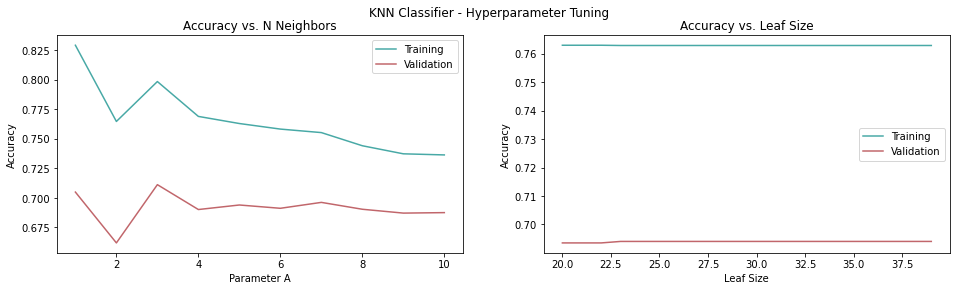

In [18]:
fig, ax = plt.subplots(1, 2,  figsize=(16,4))

ax[0].plot(n_neighbors, n_train_acc, label = 'Training', color='#48A9A6')
ax[0].plot(n_neighbors, n_val_acc, label = 'Validation', color='#C1666B')
ax[0].set_title('Accuracy vs. N Neighbors')  
ax[0].set_xlabel('Parameter A')   
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc = 'best')

ax[1].plot(leaf_size, l_train_acc, label = 'Training', color='#48A9A6')
ax[1].plot(leaf_size, l_val_acc, label = 'Validation', color='#C1666B')
ax[1].set_title('Accuracy vs. Leaf Size') 
ax[1].set_xlabel('Leaf Size')
ax[1].set_ylabel('Accuracy')
ax[1].legend(loc = 'best')

plt.suptitle('KNN Classifier - Hyperparameter Tuning')
plt.show()

In [17]:
# More comprehensive 
n_neighbors = list(range(1,11))
p=[1,2]

data = [(X_train,y_cat_train),(X2_train,y2_cat_train)]
feature_sets = [a1cols,a2cols,bcols,ccols]

clf_model = []
hyperparameters = dict(n_neighbors=n_neighbors, p=p)

# Classifier
knn = KNeighborsClassifier()

# Use Random Search
clf = RandomizedSearchCV(knn, hyperparameters, cv=3)
X_train_h,y_train_h = data[0]
for i in range(4):
# Switch Data if Set C
    if i > 2:
        X_train_h,y_train_h = data[1]
    X, y = scale_split(X_train_h,y_train_h,feature_sets[i])
    best_model = clf.fit(X,y)
    p = best_model.best_estimator_.get_params()['p']
    n = best_model.best_estimator_.get_params()['n_neighbors']
    sc = best_model.best_score_
    print('Best p:', p)
    print('Best n_neighbors:',n)
    print('Best score:', sc)

    clf_model.append((p,n,sc))
    progress()

Best p: 1
Best n_neighbors: 7
Best score: 0.7163625832609325
-
Best p: 2
Best n_neighbors: 1
Best score: 0.7924864802669428
-
Best p: 2
Best n_neighbors: 1
Best score: 0.8709621396318165
-
Best p: 2
Best n_neighbors: 1
Best score: 0.5534290271132377
-


In [20]:
def best_test(features,n,p,X = X_train,y = y_cat_train,X_test = X_test,y_test = y_cat_test):
    X, y = scale_split(X,y,features)
    test = scale(X_test,features)

    knn = KNeighborsClassifier(n_neighbors=n,p=p)

    knn.fit(X,y)

    test_pred = knn.predict(test)

    test_acc = get_acc(y_test,test_pred)
    return test_acc

# Set A1
a1_score = best_test(a1cols,clf_model[0][1],clf_model[0][0])
# Set A2
a2_score = best_test(a2cols,clf_model[1][1],clf_model[1][0])
# Set B
b_score = best_test(bcols,clf_model[2][1],clf_model[2][0])
# Set C
c_score = best_test(ccols,clf_model[3][1],clf_model[3][0],X2_train,y2_cat_train,X2_test, y2_cat_test)

In [21]:
print('A1 Test Acc:',a1_score)
print('A2 Test Acc:',a2_score)
print('B Test Acc:',b_score)
print('C Test Acc:',c_score)

A1 Test Acc: 0.6601
A2 Test Acc: 0.6409
B Test Acc: 0.6562
C Test Acc: 0.4259


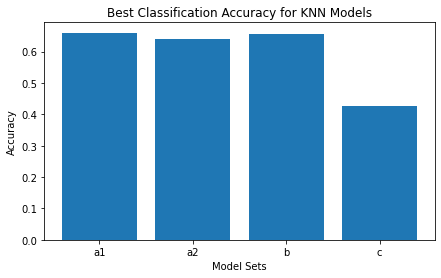

In [26]:
fig, ax = plt.subplots(figsize=(7,4))
scores = [a1_score,a2_score,b_score,c_score]
sets = ['a1','a2','b','c']
ax.bar(sets,scores)
ax.set_title('Best Classification Accuracy for KNN Models')  
ax.set_xlabel('Model Sets')   
ax.set_ylabel('Accuracy');